In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
plt.rc('figure', dpi=100, figsize=(10, 5))
plt.rc('font', size=12)

C:\Users\costi\AppData\Local\Temp\ipykernel_17512\1271768541.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


## Assessing missingness through data

### Assessing missingness through data

- Suppose I believe that the missingness mechanism of a column is NMAR, MAR, or MCAR.
    - I've ruled out missing by design (a good first step).
- Can I determine the missingness mechanism by looking at the data?

### Assessing NMAR

- We can't determine if data is NMAR just by looking at the data, as whether or not data is NMAR depends on the **unobserved data**.
- To establish if data is NMAR, we must:
    - **reason about the data generating process**, or
    - collect more data.

- **Example:** Consider a dataset of survey data of students' self-reported happiness. The data contains PIDs and happiness scores; nothing else. Some happiness scores are missing. **Are happiness scores likely NMAR?**

- **Answer:** Yes. For them to be MAR, there need to be other relevant columns in the dataset, which there are not. For it to be MCAR, we'd need some reason to believe that scores were dropped at random. Without any other information, we must assume that students with lower happiness scores didn't fill out the survey.

### Assessing MAR

- Data is MAR if the missingness only depends on **observed** data.
- After reasoning about the data generating process, if you establish that data is not NMAR, then it must be either MAR or MCAR.
- The more columns we have in our dataset, the "weaker the NMAR effect" is.
    - Adding more columns -> controlling for more variables -> moving from NMAR to MAR.
    - **Example:** With no other columns, income in a census is NMAR. But once we look at location, education, and occupation, incomes are closer to being MAR.

### Assessing MCAR

- For data to be MCAR, the chance that values are missing should not depend on any other column or the values themselves.
- **Example:** Consider a dataset of phones, in which we store the screen size and price of each phone. **Some prices are missing.**

| Phone | Screen Size | Price |
| --- | --- | --- |
| iPhone 13 | 6.06 | 999 |
| Galaxy Z Fold 3 | 7.6 | NaN |
| OnePlus 9 Pro | 6.7 | 799 |
| iPhone 12 Pro Max | 6.68 | NaN |

- If prices are MCAR, then **the distribution of screen size should be the same** for:
    - phones whose prices are missing, and 
    - phones whose prices aren't missing.
- **We can use a permutation test to decide between MAR and MCAR!** We are asking the question, did these two samples come from the same underlying distribution?

### Assessing MCAR

Suppose you have a DataFrame with columns named `'col_1'`, `'col_2'`, ..., `'col_k'`, and want to test whether values in `'col_X'` are MCAR.

The following _pseudocode_ describes an algorithm for testing whether `'col_X'`'s missingness is independent of all other columns in the DataFrame:

```
for i = 1, 2, ..., k, where i != X:
    look at the distribution of col_i when col_X is missing
    look at distribution of col_i when col_X is not missing
    check if these two distributions are the same
    if so, then col_X's missingness doesn't depend on col_i
    if not, col_X is MAR dependent on col_i
if all pairs of distributions were the same, 
then col_X is MCAR
```

We need to make precise what we mean by "the same"!

### Example: Heights

- Let's load in Galton's heights dataset from DSC 10.
- We will start with a complete dataset of child heights, child genders, and parent heights.
- We will then **artifically introduce missing values** such that the values are MCAR.

In [2]:
heights = pd.read_csv('data/midparent.csv')
heights = heights.rename(columns={'childHeight': 'child'})
heights = heights[['father', 'mother', 'gender', 'child']]
heights.head()

,father,mother,gender,child
0,78.5,67.0,male,73.2
1,78.5,67.0,female,69.2
2,78.5,67.0,female,69.0
3,78.5,67.0,female,69.0
4,75.5,66.5,male,73.5


Note that there currently aren't any missing values in `heights`.

In [3]:
heights.isna().mean()

father    0.0
mother    0.0
gender    0.0
child     0.0
dtype: float64

We have three numerical columns – `'father'`, `'mother'`, and `'child'`. Let's visualize them simultaneously.

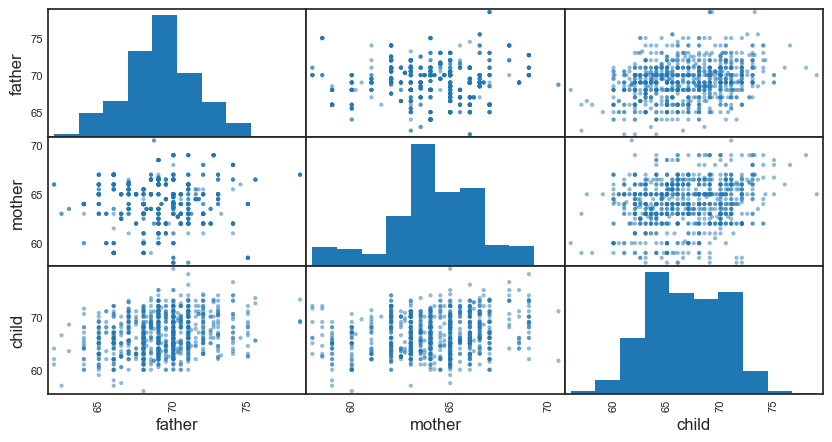

In [4]:
pd.plotting.scatter_matrix(heights.drop('gender', axis=1));

### Simulating MCAR data

- We will make `'child'` MCAR by taking a random subset of `heights` and setting the corresponding `'child'` heights to `np.NaN`.
- This is equivalent to flipping a (biased) coin for each row. 
    - If heads, we delete the `'child'` height.
- **You will not do this in practice!**

In [5]:
np.random.seed(42) # So that we get the same results each time (for lecture)

heights_mcar = heights.copy()
idx = heights_mcar.sample(frac=0.3).index
heights_mcar.loc[idx, 'child'] = np.NaN

In [6]:
heights_mcar.head(10)

,father,mother,gender,child
0,78.5,67.0,male,73.2
1,78.5,67.0,female,69.2
2,78.5,67.0,female,NaN
3,78.5,67.0,female,69.0
4,75.5,66.5,male,73.5
5,75.5,66.5,male,NaN
6,75.5,66.5,female,65.5
7,75.5,66.5,female,NaN
8,75.0,64.0,male,71.0
9,75.0,64.0,female,68.0


In [7]:
heights_mcar.isna().mean()

father    0.000000
mother    0.000000
gender    0.000000
child     0.299786
dtype: float64

Aside: Why is the value for `'child'` in the above Series not exactly 0.3?

### Verifying that child heights are MCAR in `heights_mcar`

- Each row of `heights_mcar` belongs to one of two **groups**:
    - Group 1: `'child'` is missing.
    - Group 2: `'child'` is not missing.
- We need to look at the distributions of every other column – `'gender'`, `'mother'`, and `'father'` – separately for these two groups, and check to see if they are similar.

In [8]:
heights_mcar.head()

,father,mother,gender,child
0,78.5,67.0,male,73.2
1,78.5,67.0,female,69.2
2,78.5,67.0,female,NaN
3,78.5,67.0,female,69.0
4,75.5,66.5,male,73.5


### Comparing null and non-null `'child'` distributions for `'gender'`

In [9]:
gender_dist = (
    heights_mcar
    .assign(child_missing=heights_mcar['child'].isna())
    .pivot_table(index='gender', columns='child_missing', aggfunc='size')
)

gender_dist = gender_dist / gender_dist.sum()
gender_dist

child_missing,False,True
gender,,
female,0.487768,0.478571
male,0.512232,0.521429


- Note that here, each column is a separate distribution that adds to 1.
- The two columns look similar, which is evidence that `'child'`'s missingness does not depend on `'gender'`.
    - Knowing that the child is `'female'` doesn't make it any more or less likely that their height is missing than knowing if the child is `'male'`.

### Comparing null and non-null `'child'` distributions for `'gender'`

- In the previous slide, we saw that the distribution of `'gender'` is similar whether or not `'child'` is missing.
- To make precise what we mean by "similar", we can run a permutation test. We are comparing two distributions:
    1. Distribution of `'gender'` when `'child'` is missing.
    2. Distribution of `'gender'` when `'child'` is not missing.
- What test statistic do we use to compare categorical distributions?

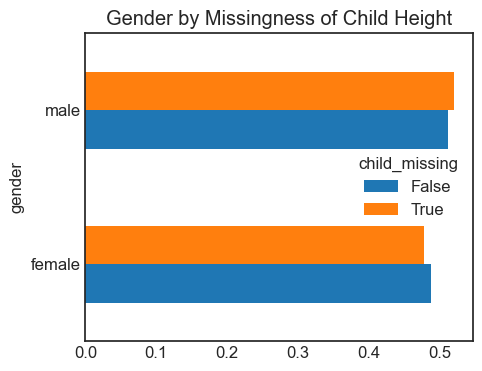

In [10]:
gender_dist.plot(kind='barh', figsize=(5, 4), title='Gender by Missingness of Child Height');

**Answer:** 
- Total variation distance.
- However, with only two categories, the TVD is the same as the absolute difference in proportions for either category.

### Simulation

The code to run our simulation largely looks the same as in previous permutation tests.

In [14]:
shuffled = heights_mcar.copy()
shuffled['child_missing'] = shuffled['child'].isna()

n_repetitions = 500
tvds = []
for _ in range(n_repetitions):
    
    # Shuffling genders and assigning back to the DataFrame
    shuffled['gender'] = np.random.permutation(shuffled['gender'])
    
    # Computing and storing TVD
    pivoted = (
        shuffled
        .pivot_table(index='child_missing', columns='gender', aggfunc='size')
        .apply(lambda x: x / x.sum(), axis=1)
    )
    
    tvd = pivoted.diff().iloc[-1].abs().sum() / 2
    tvds.append(tvd)

In [18]:
tvds = []
shuffled = heights_mcar.copy()
shuffled['child_missing'] = shuffled['child'].isna()
pivoted = (
    shuffled
    .pivot_table(index='child_missing', columns='gender', aggfunc='size')
    .apply(lambda x: x / x.sum(), axis=1)
)

tvd = pivoted.diff().iloc[-1].abs().sum() / 2
tvds.append(tvd)

In [19]:
pivoted

gender,female,male
child_missing,,
False,0.487768,0.512232
True,0.478571,0.521429


In [15]:
obs_tvd = gender_dist.diff(axis=1).iloc[:, -1].abs().sum() / 2
obs_tvd

0.009196155526430771

### Results

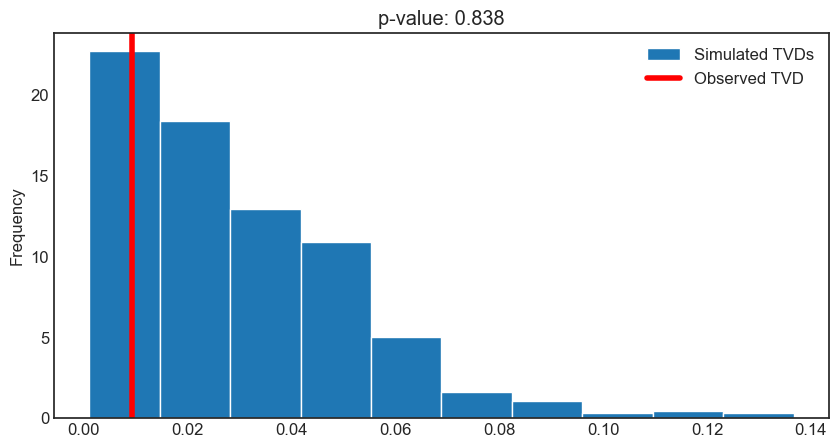

In [13]:
pval = np.mean(tvds >= obs_tvd)

pd.Series(tvds).plot(kind='hist', density=True, ec='w', bins=10, title=f'p-value: {pval}', label='Simulated TVDs')
plt.axvline(x=obs_tvd, color='red', linewidth=4, label='Observed TVD')
plt.legend();

- We fail to reject the null.
- Recall, the null stated that the distribution of `'gender'` when `'child'` is missing is the same as the distribution of `'gender'` when `'child'` is not missing.
- Hence, we conclude that the missingness in the `'child'` column is not dependent on `'gender'`.

### Comparing null and non-null `'child'` distributions for `'father'`

- We again must compare two distributions:
    1. Distribution of `'father'` when `'child'` is missing.
    2. Distribution of `'father'` when `'child'` is not missing.
- If the distributions are similar, we conclude that the missingness of `'child'` is not dependent on the height of the `'father'`.
- We can again use a permutation test.

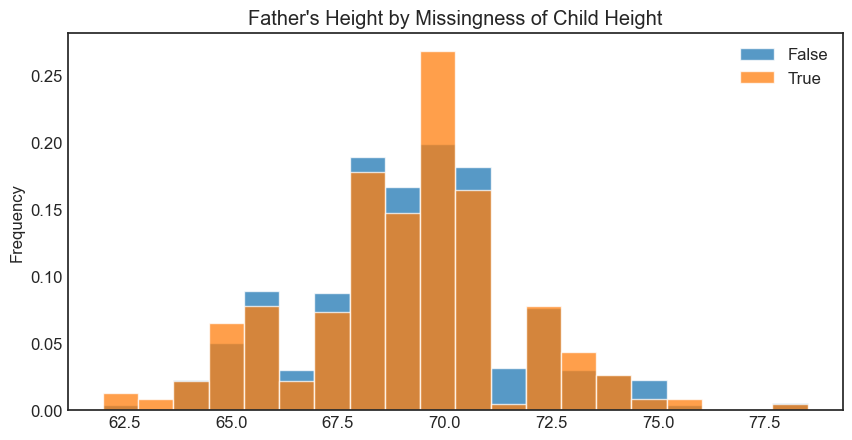

In [14]:
(
    heights_mcar
    .assign(child_missing=heights_mcar['child'].isna())
    .groupby('child_missing')['father']
    .plot(kind='hist', density=True, alpha=0.75, ec='w', bins=20, legend=True, 
          title="Father's Height by Missingness of Child Height")
);

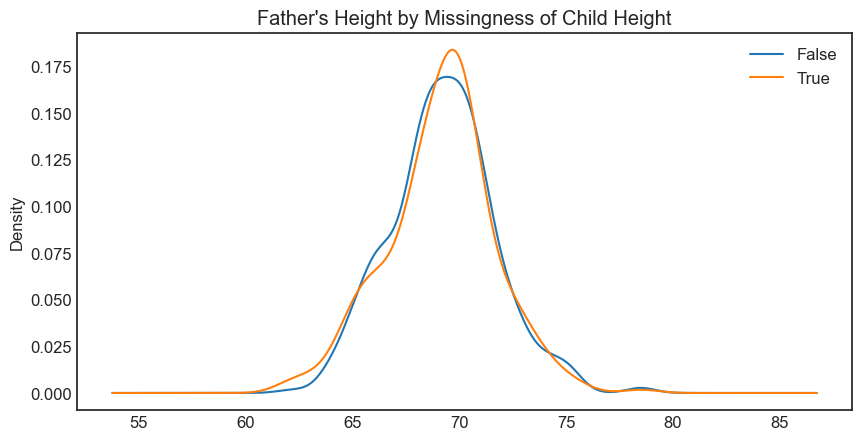

In [15]:
(
    heights_mcar
    .assign(child_missing=heights_mcar['child'].isna())
    .groupby('child_missing')['father']
    .plot(kind='kde', legend=True, title="Father's Height by Missingness of Child Height")
);

### Concluding that `'child'` is MCAR

- We need to run three permutation tests – one for each column in `heights_mcar` other than `'child'`.
- For every other column, if we **fail to reject the null** that the distribution of the column when `'child'` is missing is the same as the distribution of the column when `'child'` is not missing, then we can conclude `'child'` is MCAR.
    - In such a case, its missingness is not tied to any other columns.
    - For instance, knowing a child's father's height or gender doesn't make it any more or less likely that their height is missing.

### Simulating MAR data

Now, we will make `'child'` heights MAR by deleting `'child'` heights according to a random procedure that **depends on other columns**.

In [16]:
np.random.seed(42) # So that we get the same results each time (for lecture)

def make_missing(r):
    rand = np.random.uniform() # Random real number between 0 and 1
    if r['father'] > 72 and rand < 0.5:
        return np.NaN
    elif r['gender'] == 'female' and rand < 0.3:
        return np.NaN
    else:
        return r['child']
    
heights_mar = heights.copy()
heights_mar['child'] = heights_mar.apply(make_missing, axis=1)

In [17]:
heights_mar.head()

,father,mother,gender,child
0,78.5,67.0,male,NaN
1,78.5,67.0,female,69.2
2,78.5,67.0,female,69.0
3,78.5,67.0,female,69.0
4,75.5,66.5,male,NaN


### Comparing null and non-null `'child'` distributions for `'gender'`, again

This time, the distribution of `'gender'` in the two groups is very different.

In [18]:
gender_dist = (
    heights_mar
    .assign(child_missing=heights_mar['child'].isna())
    .pivot_table(index='gender', columns='child_missing', aggfunc='size')
)

gender_dist = gender_dist / gender_dist.sum()
gender_dist

child_missing,False,True
gender,,
female,0.397386,0.881657
male,0.602614,0.118343


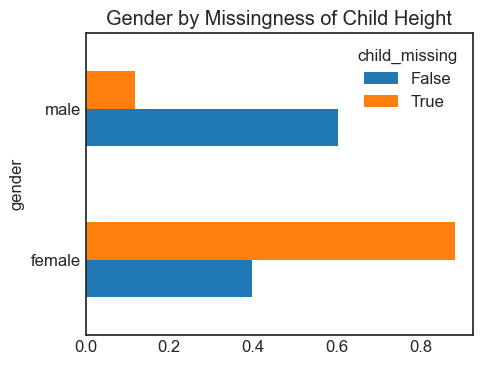

In [19]:
gender_dist.plot(kind='barh', figsize=(5, 4), title='Gender by Missingness of Child Height');

- **Question:** If we take the average of the non-null `'child'` heights in the dataset with missing values, will it be less than or greater than the average `'child'` height in the full dataset?

- **Answer:** 
Because: 
    - `'child'` height tends to be missing much more frequently when the child is `'female'`, and 
    - adult females tend to be shorter than adult males on average, 
    - the average `'child'` height in the dataset with missing values will be **greater than** the average `'child'` height in the full dataset. 

### Comparing null and non-null `'child'` distributions for `'father'`, again

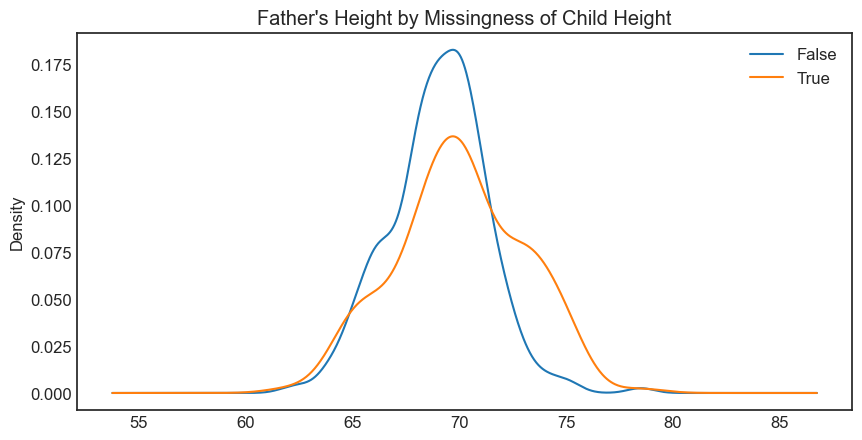

In [20]:
(
    heights_mar
    .assign(child_missing=heights_mar['child'].isna())
    .groupby('child_missing')['father']
    .plot(kind='kde', legend=True, title="Father's Height by Missingness of Child Height")
);

**Observation:**
- The above two distributions look quite different.
    - This is because we artificially created missingness in the dataset in a way that depended on `'father'` and `'gender'`.
- However, their difference in means is likely small.
- If we ran a permutation test with the difference in means as our test statistic, our observed test statistic would be very small.
    - **Using just the difference in means, it is hard to tell these two distributions apart.**